In [2]:
# Pengujian Missing Value
import pandas as pd

# Nama file dataset
file_name = "Modified_TN_TX_Varied_Gabungan_Semuanya.csv"

# Daftar nilai yang  di anggap sebagai data hilang
nilai_hilang = ['-', '8888', '9999']

try:
    df = pd.read_csv(file_name, delimiter=';', na_values=nilai_hilang) # Membaca file CSV, menggunakan titik koma sebagai pemisah
    print(f"--- Hasil Uji Missing Value pada File: {file_name} ---\n") # Memberitahu pandas untuk menganggap nilai di 'nilai_hilang' sebagai NaN (kosong)
    
    # Menghitung jumlah nilai yang hilang (NaN) di setiap kolom
    missing_values = df.isnull().sum()
    
    # Menghitung total semua nilai yang hilang di seluruh dataset
    total_missing = missing_values.sum()
    
    # Menampilkan hasil
    if total_missing > 0:
        # Menghitung total baris untuk kalkulasi persentase
        total_rows = len(df)
        
        # Menghitung persentase missing value
        missing_percentage = (missing_values / total_rows) * 100
        
        # Membuat tabel hasil
        hasil_df = pd.DataFrame({
            'Jumlah Hilang': missing_values,
            'Persentase (%)': missing_percentage
        })
        
        print("Ditemukan nilai yang hilang pada kolom berikut:")
        # Filter dan tampilkan hanya kolom yang memiliki missing value
        print(hasil_df[hasil_df['Jumlah Hilang'] > 0].round(2)) # .round(2) untuk membulatkan persentase
        
        print(f"\nTotal semua data yang hilang: {total_missing}")
    else:
        print("Tidak ada data yang hilang di dalam dataset")

except FileNotFoundError:
    print(f"Error: File '{file_name}' tidak ditemukan. Pastikan file berada di folder yang sama.")
except Exception as e:
    print(f"Terjadi error: {e}")

--- Hasil Uji Missing Value pada File: Modified_TN_TX_Varied_Gabungan_Semuanya.csv ---

Ditemukan nilai yang hilang pada kolom berikut:
        Jumlah Hilang  Persentase (%)
TN                  3            0.33
TX                  2            0.22
TAVG                3            0.33
RH_AVG              1            0.11
RR                 55            6.03
SS                  5            0.55

Total semua data yang hilang: 69


In [ ]:
# Pengujian Outlier
import pandas as pd
import numpy as np

# Nama file dataset
file_name = "Modified_TN_TX_Varied_Gabungan_Semuanya.csv"
nilai_hilang = ['-', '8888', '9999']

try:
    # Memuat dan Bersihkan Missing Value
    df = pd.read_csv(file_name, delimiter=';', na_values=nilai_hilang)
    df.interpolate(method='linear', inplace=True)
    print("Data berhasil dimuat dan dibersihkan dari missing value.")

    # Menerapkan Transformasi Logaritmik pada Kolom Spesifik
    kolom_untuk_transformasi = ['RR']
    print("\n--- Proses Transformasi Logaritmik ---")
    for kolom in kolom_untuk_transformasi:
        
        df[f'{kolom}_log'] = np.log1p(df[kolom]) # Menggunakan np.log1p(x) yang setara dengan np.log(x + 1)
        print(f"INFO: Transformasi log(x+1) diterapkan pada kolom '{kolom}', hasil disimpan di '{kolom}_log'.") # Ini penting untuk menangani nilai 0

    # Menguji Outlier IQR pada Semua Kolom Numerik
    print("\n--- Hasil Uji Outlier (Setelah Transformasi) ---")
    hasil_outlier = []

    # Mendapatkan semua kolom numerik, termasuk kolom _log yang baru dibuat
    kolom_numerik = df.select_dtypes(include=np.number).columns.tolist()
    
    for kolom in kolom_numerik:
        # Menghitung Q1, Q3, dan IQR
        Q1 = df[kolom].quantile(0.25)
        Q3 = df[kolom].quantile(0.75)
        IQR = Q3 - Q1

        # Menghitung batas bawah dan batas atas
        batas_bawah = Q1 - (1.5 * IQR)
        batas_atas = Q3 + (1.5 * IQR)

        # Mengidentifikasi dan menghitung outlier
        jumlah_outlier = ((df[kolom] < batas_bawah) | (df[kolom] > batas_atas)).sum()
        persentase_outlier = (jumlah_outlier / len(df)) * 100
        
        # Menambahkan hasil ke list
        hasil_outlier.append({
            "Variabel": kolom,
            "Jumlah Outlier": jumlah_outlier,
            "Persentase Outlier (%)": persentase_outlier
        })

    # Menampilkan Hasil dalam Bentuk Tabel
    hasil_df = pd.DataFrame(hasil_outlier)
    print(hasil_df.to_string(index=False))

except FileNotFoundError:
    print(f"Error: File '{file_name}' tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")

✅ Data berhasil dimuat dan dibersihkan dari missing value.

--- Proses Transformasi Logaritmik ---
INFO: Transformasi log(x+1) diterapkan pada kolom 'RR', hasil disimpan di 'RR_log'.

--- Hasil Uji Outlier (Setelah Transformasi) ---
Variabel  Jumlah Outlier  Persentase Outlier (%)
      TN               0                0.000000
      TX               0                0.000000
    TAVG               4                0.438596
  RH_AVG               0                0.000000
      RR             136               14.912281
      SS               0                0.000000
    FF_X               9                0.986842
   DDD_X               0                0.000000
  FF_AVG             348               38.157895
  RR_log               2                0.219298


C:\Users\msi\AppData\Local\Temp\ipykernel_5000\2831259915.py:12: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [9]:
# Pengujian Outlier Variabel FF_AVG
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Lokasi dataset
file_path = 'Modified_TN_TX_Varied_Gabungan_Semuanya.csv'

# Memuat dataset
try:
    df = pd.read_csv(file_path, delimiter=';') # Menggunakan titik koma (;) sebagai pemisah
    print("File berhasil dimuat.")
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di lokasi '{file_path}'")
    exit()

# Pra-pemrosesan kolom 'FF_AVG'
# Mengubah kolom menjadi tipe numerik. Nilai yang tidak valid akan menjadi NaN (Not a Number)
df['FF_AVG_numeric'] = pd.to_numeric(df['FF_AVG'], errors='coerce')

# Memeriksa apakah ada baris yang nilainya kosong/NaN setelah konversi
if df['FF_AVG_numeric'].isnull().any():
    print(f"Ditemukan {df['FF_AVG_numeric'].isnull().sum()} nilai kosong/non-numerik di 'FF_AVG'. Baris ini akan dikecualikan dari analisis.")
    # Buat DataFrame baru tanpa baris yang bermasalah untuk dianalisis
    df_analysis = df.dropna(subset=['FF_AVG_numeric']).copy()
else:
    df_analysis = df.copy()

# Pastikan tipe data adalah float untuk proses scaling
df_analysis['FF_AVG_numeric'] = df_analysis['FF_AVG_numeric'].astype(float)

# Terapkan DBSCAN untuk Deteksi Outlier
# Siapkan data untuk di-scaling
data_to_scale = df_analysis[['FF_AVG_numeric']].copy()

# Lakukan standardisasi (scaling) pada data
scaler = StandardScaler()
data_to_scale['FF_AVG_scaled'] = scaler.fit_transform(data_to_scale[['FF_AVG_numeric']])

# Terapkan algoritma DBSCAN
# `eps`: Jarak maksimum antar titik untuk dianggap bertetangga
# `min_samples`: Jumlah minimum titik untuk membentuk sebuah klaster
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(data_to_scale[['FF_AVG_scaled']])

# Identifikasi dan laporkan hasil outlier
# Tambahkan hasil deteksi (klaster) ke DataFrame analisis
# Outlier ditandai dengan label -1 oleh DBSCAN
df_analysis['is_outlier_dbscan'] = clusters == -1

# Gabungkan hasil kembali ke DataFrame asli
df['is_outlier_dbscan'] = df_analysis['is_outlier_dbscan']

# Ambil baris yang merupakan outlier
outliers = df[df['is_outlier_dbscan'] == True]
outlier_percentage = (len(outliers) / len(df_analysis)) * 100

# Tampilkan ringkasan hasil di console
print("---   HASIL DETEKSI OUTLIER (DBSCAN)  ---")
print(f"Total baris data yang dianalisis: {len(df_analysis)}")
print(f"Jumlah outlier yang terdeteksi: {len(outliers)}")
print(f"Persentase outlier: {outlier_percentage:.2f}%")

if not outliers.empty:
    print("\nData yang teridentifikasi sebagai outlier:")
    print(outliers[['TANGGAL', 'FF_AVG']])

File berhasil dimuat.
---   HASIL DETEKSI OUTLIER (DBSCAN)  ---
Total baris data yang dianalisis: 912
Jumlah outlier yang terdeteksi: 7
Persentase outlier: 0.77%

Data yang teridentifikasi sebagai outlier:
        TANGGAL  FF_AVG
1    02/01/2023       6
3    04/01/2023       5
102  13/04/2023       0
732  02/01/2025       0
765  04/02/2025       5
766  05/02/2025       5
876  26/05/2025       0


Data berhasil dimuat dan dibersihkan.

Matriks Korelasi Pearson:
              TN        TX      TAVG    RH_AVG        RR        SS      FF_X  \
TN      1.000000  0.999465  0.017718 -0.041559  0.026920  0.017838 -0.041300   
TX      0.999465  1.000000  0.017048 -0.041319  0.027772  0.017625 -0.041152   
TAVG    0.017718  0.017048  1.000000 -0.732727 -0.196783  0.399693  0.037176   
RH_AVG -0.041559 -0.041319 -0.732727  1.000000  0.279665 -0.538071 -0.142273   
RR      0.026920  0.027772 -0.196783  0.279665  1.000000 -0.246574 -0.016391   
SS      0.017838  0.017625  0.399693 -0.538071 -0.246574  1.000000  0.014486   
FF_X   -0.041300 -0.041152  0.037176 -0.142273 -0.016391  0.014486  1.000000   
DDD_X   0.023984  0.022853 -0.171507  0.302492  0.092003 -0.199354 -0.039548   
FF_AVG -0.029969 -0.029626  0.130565 -0.245232 -0.038336  0.100905  0.647719   

           DDD_X    FF_AVG  
TN      0.023984 -0.029969  
TX      0.022853 -0.029626  
TAVG   -0.171507  0.130565  
RH_AVG  0.302492 -

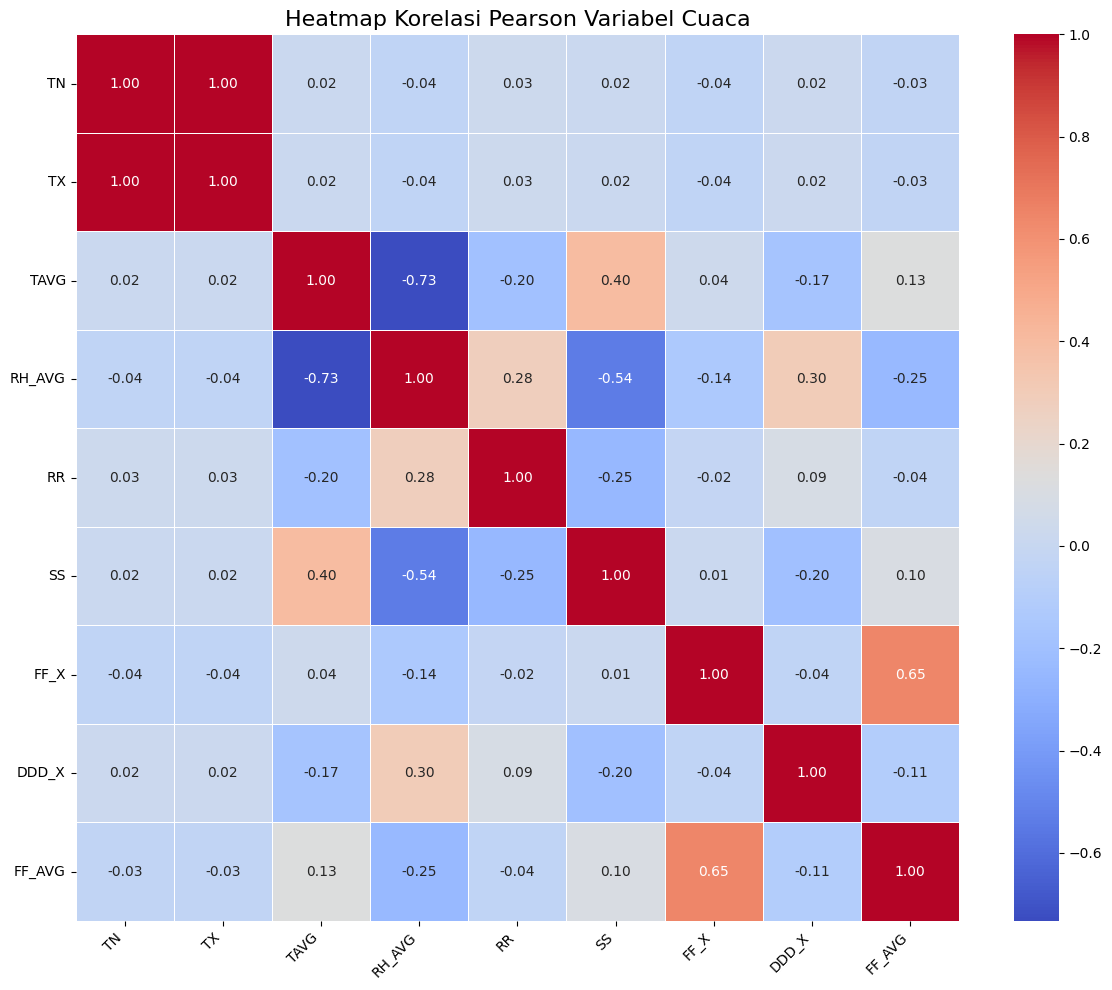

In [13]:
# Pengujian Korelasi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Nama file dataset
file_name = "Modified_TN_TX_Varied_Gabungan_Semuanya.csv"
nilai_hilang = ['-', '8888','9999']

try:
    # Memuat dan membersihkan Data
    df = pd.read_csv(file_name, delimiter=';', na_values=nilai_hilang)

    # Menghapus kolom tanggal
    df = df.drop('TANGGAL', axis=1)

    # Mengisi data hilang dengan interpolasi
    df.interpolate(method='linear', inplace=True)
    print("Data berhasil dimuat dan dibersihkan.")

    # Menghitung Matriks Korelasi Pearson
    correlation_matrix = df.corr(method='pearson')
    print("\nMatriks Korelasi Pearson:")
    print(correlation_matrix)

    # Membuat dan menampilkan Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    
    plt.title('Heatmap Korelasi Pearson Variabel Cuaca', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout() # Memastikan label tidak terpotong
    
    # Menyimpan heatmap sebagai file gambar
    #output_filename = 'heatmap_korelasi_pearson.png'
    #plt.savefig(output_filename)
    
    #print(f"\nHeatmap berhasil dibuat dan disimpan sebagai '{output_filename}'")

except FileNotFoundError:
    print(f"Error: File '{file_name}' tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")

✅ Data berhasil dimuat dan dibersihkan.
✅ Transformasi logaritmik diterapkan pada RR dan FF_AVG.

Fitur (X) yang akan dinormalisasi: ['TN', 'TX', 'RR', 'SS', 'FF_X']
Target (y) yang akan dinormalisasi: ['TAVG', 'RH_AVG', 'FF_AVG', 'DDD_X']

--- Proses Normalisasi Selesai ---

--- Membuat Visualisasi Box Plot ---


C:\Users\msi\AppData\Local\Temp\ipykernel_5000\498505186.py:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


<Figure size 1500x800 with 0 Axes>

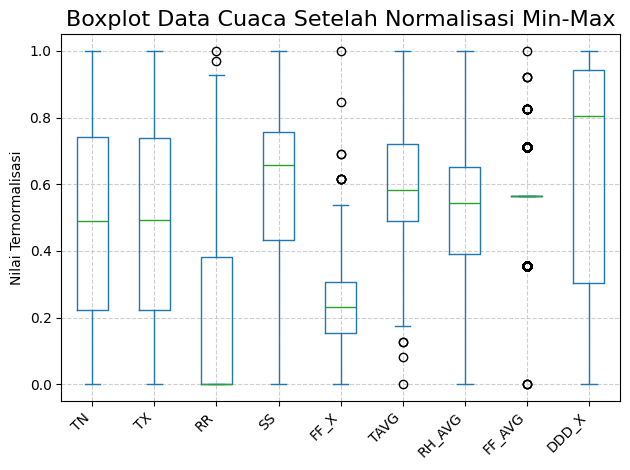

In [ ]:
# Normalisasi Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Nama file dataset
file_name = "Modified_TN_TX_Varied_Gabungan_Semuanya.csv"
nilai_hilang = ['-', '8888', '9999']
output_csv_filename = "gemini_log_then_minmax_normalized_data.csv"
output_plot_filename = "boxplot_log_normalized.png"

try:
    # Memuat dan Bersihkan Data
    df = pd.read_csv(file_name, delimiter=';', na_values=nilai_hilang)
    df.interpolate(method='linear', inplace=True)
    df_cleaned = df.drop('TANGGAL', axis=1)
    print("Data berhasil dimuat dan dibersihkan.")

    # Transformasi Logaritmik (log(x+1))
    df_cleaned['RR'] = np.log1p(df_cleaned['RR'])
    df_cleaned['FF_AVG'] = np.log1p(df_cleaned['FF_AVG'])
    print("Transformasi logaritmik diterapkan pada RR dan FF_AVG.")

    # Mendefinisikan Fitur dan Target menggunakan kolom yang sudah ditransformasi
    targets = ['TAVG', 'RH_AVG', 'FF_AVG', 'DDD_X']
    features = ['TN', 'TX', 'RR', 'SS', 'FF_X']
    
    X = df_cleaned[features]
    y = df_cleaned[targets]
    
    print("\nFitur (X) yang akan dinormalisasi:", X.columns.tolist())
    print("Target (y) yang akan dinormalisasi:", y.columns.tolist())

    # Inisialisasi dan Lakukan Normalisasi Min-Max
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    print("\n--- Proses Normalisasi Selesai ---")

    # Menggabungkan Hasil untuk Disimpan dan Divisualisasikan
    df_X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    df_y_scaled = pd.DataFrame(y_scaled, columns=y.columns)
    df_normalized = pd.concat([df_X_scaled, df_y_scaled], axis=1)
        
    # Buat Visualisasi Box Plot
    print("\n--- Membuat Visualisasi Box Plot ---")
    plt.figure(figsize=(15, 8))
    df_normalized.plot(kind='box')
    plt.title('Boxplot Data Cuaca Setelah Normalisasi Min-Max', fontsize=16)
    plt.ylabel('Nilai Ternormalisasi')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # Menyimpan box plot sebagai gambar
    # plt.savefig(output_plot_filename)

except FileNotFoundError:
    print(f"Error: File '{file_name}' tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")